June 2018

Jupiter Notebook 5.5.0 (Python 3.5.5, Pandas 0.23.0, scikit-learn 0.19.1)

IPython Book #3 of 3

The goal of this exercise is to build a predictive model to determine which encounters will be followed by the patient being readmitted to the hospital within 30 days. 

In [65]:
# Import useful packages
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.utils import resample


In [100]:
# Set the directory
# directory = [[ENTER DIRECTORY PATH]]



In [110]:
# Load the saved 'result' dataset (deduped, created in IPython Notebook #2)
result = pd.read_pickle("result_book2.pickle" )


In [111]:
result.columns


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'A1Cresult', 'metformin', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'change', 'diabetesMed', 'readmitted', 'target', 'n_code_1', 'n_code_2',
       'n_code_3'],
      dtype='object')

In [112]:
# Note that for modeling, I do not need variables such as 'encounter_id', 'patient_nbr' and 'readmitted'. So I drop them here.
result = result.drop([ 'encounter_id', 'patient_nbr', 'readmitted'], axis=1)


In [113]:
result.shape


(69990, 30)

# Encoding categorical variables

Before proceeding to the modeling stage, I need to encode labels of categorical variables, so that instead of labels such as 'female', 'male' and 'unknown', I would have numeric labels such as 0, 1, and 2 instead.

In [114]:
# Identify categorical variable names only
cols_categorical = result.describe(exclude = [np.number]).columns
cols_categorical


Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'A1Cresult', 'change', 'diabetesMed', 'n_code_1',
       'n_code_2', 'n_code_3'],
      dtype='object')

In [115]:
result.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,target,n_code_1,n_code_2,n_code_3
0,Caucasian,Female,[50-60),2,1,1,8,?,Cardiology,77,...,1,0,0,1,Ch,Yes,1,nan,4.0,10.0
1,Caucasian,Female,[50-60),3,1,1,2,?,Surgery-Neuro,49,...,0,0,0,0,No,No,0,nan,nan,24.0
2,Caucasian,Female,[80-90),1,3,7,4,MC,InternalMedicine,68,...,0,0,0,0,No,Yes,0,18.0,3.0,nan
3,Caucasian,Female,[80-90),1,1,7,3,?,InternalMedicine,46,...,1,0,0,0,Ch,Yes,0,nan,6.0,4.0
4,AfricanAmerican,Female,[30-40),1,1,7,5,?,InternalMedicine,49,...,0,0,0,0,No,Yes,0,nan,nan,24.0


In [116]:
# Encode categorical variables
le = preprocessing.LabelEncoder()

# Apply le.fit_transform to categorical columns
result[cols_categorical] = result[cols_categorical].apply(le.fit_transform)
result.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,target,n_code_1,n_code_2,n_code_3
0,3,0,5,1,0,0,8,0,4,77,...,1,0,0,1,0,1,1,34,19,1
1,3,0,5,2,0,0,2,0,64,49,...,0,0,0,0,1,0,0,34,35,14
2,3,0,8,0,14,14,4,8,18,68,...,0,0,0,0,1,1,0,8,17,35
3,3,0,8,0,0,14,3,0,18,46,...,1,0,0,0,0,1,0,34,25,19
4,1,0,3,0,0,14,5,0,18,49,...,0,0,0,0,1,1,0,34,35,14


# A comment on missing values

Previously I checked that numeric variables contained no missing values. Categorical variables had missing values, including some with a substantial number of missing values (medical speciality - 47%, payer code - 42%). Besides, decreasing the cardinality of diag_1, diag_2, and diag_3 introduced a lot of missing values. I follow the approach of B. Strack et al by keeping the missing values and treating them as a separate category. 

Note that missing numeric values could have been replaced by mean values, for example. With categorical variables, it is more sensible to just keep the missing values as is, as a separate category (for which one could also create dummy variables).

# Create train, validation, and test data sets

In this IPython Notebook, I explore decision tree models that do not require typical data preprocessing necessary for, say, a logistic regression (e.g., demeaning and normalization of numeric variables, and one-hot encoding or creation of dummy variables for categorical variables). So I skip this preprocessing step and proceed to create the training, validation and test data sets. 

[Note, I could have done cross-validation, but due to the shortness of time, I am opting for a more straighforward modeling approach using one validation set.] 

I randomly allocate 60% of the original data to the training set, 20% to the validation set, and 20% to the test set.

In [16]:
train=result.sample(frac=0.6,replace = False, random_state=200)
intermed =result.drop(train.index)
valid =intermed.sample(frac=0.5,replace = False, random_state=300)
test = intermed.drop(valid.index)
print('Length of train set:', len(train))
print('Length of validation set:', len(valid))
print('Length of test set:', len(test))
print('Length of the original dataset:', len(result))
print('Fraction of obs in train set:', len(train)/len(result))
print('Fraction of obs in validation set: ', len(valid)/len(result))
print('Fraction of obs in test set:', len(test)/len(result))



Length of train set: 41994
Length of validation set: 13998
Length of test set: 13998
Length of the original dataset: 69990
Fraction of obs in train set: 0.6
Fraction of obs in validation set:  0.2
Fraction of obs in test set: 0.2


# Decision Tree Modeling

Remember that we want to predict whether the patient will be readmitted to the hospital within 30 days of the discharge date for the current encounter (target variable = 1, and 0 otherwise).

First, I fit an unregularized decision tree classifier to the train data using criterion 'entropy'. I check which attributes are important by displaying a bar chart showing feature importance, as measured by information gain or decrease in entropy associated with the given variable.

Then I also show a list of features ranked by information gain.


In [17]:
# Fit an unregularized decision tree classifier on the train set using criterion 'entropy'
clf_base = DecisionTreeClassifier(criterion='entropy')  # 'base' for 'baseline'
clf_base = clf_base.fit(train.drop(['target'], axis=1),train['target'])


In [18]:
def feature_importance(clf, train):

    """ this function produces a bar chart of feature importance and gives a list of ranked features
    (all using training data)"""
    
    fig, ax = plt.subplots(figsize=(15, 10))
    width = 1
    plt.title('Feature Importance', size=18)
    ax.bar(np.arange(len(train.drop('target',1).columns)), clf.feature_importances_, width, color='r', edgecolor='k')
    ax.set_xticks(np.arange(len(clf.feature_importances_)))
    ax.set_xticklabels(train.drop('target',1).columns.values, rotation = 90, size=14)
    ax.set_ylabel("Feature's Information Gain", size=14)
    plt.show()

    d = {}
    for i in range(len(train.drop('target',1).columns)):
        d[train.drop('target',1).columns[i]]=format(clf.feature_importances_[i], '.3f')
    print('Features by Importance (Information gain or decrease in entropy)')

    return sorted(d.items(), key=lambda x: x[1], reverse=True)
    


Feature Importance for DT trained on the initial training data


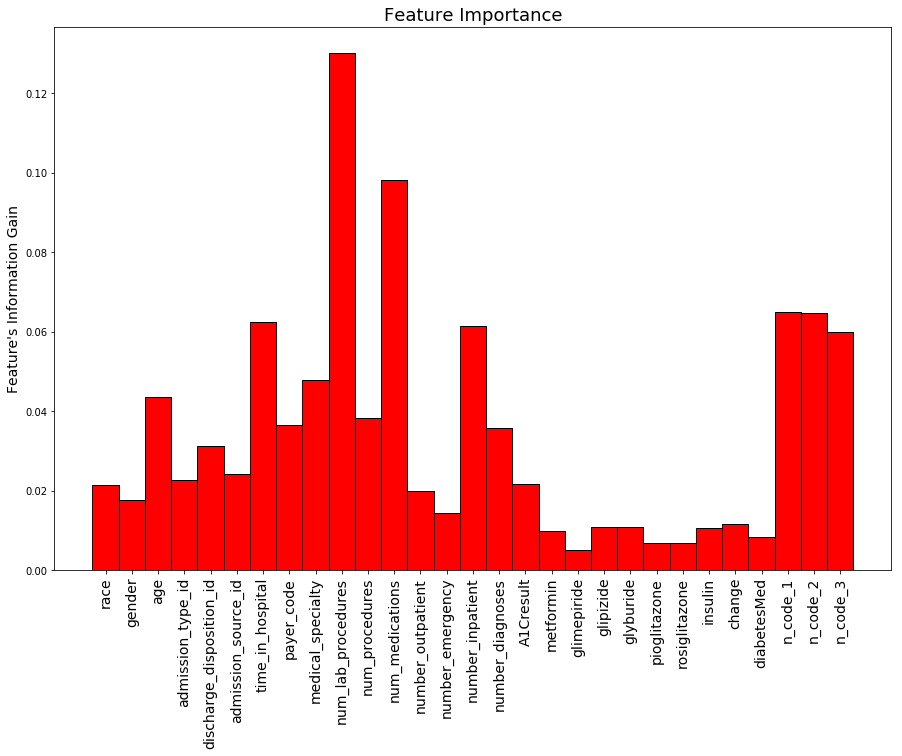

Features by Importance (Information gain or decrease in entropy)


[('num_lab_procedures', '0.130'),
 ('num_medications', '0.098'),
 ('n_code_2', '0.065'),
 ('n_code_1', '0.065'),
 ('time_in_hospital', '0.063'),
 ('number_inpatient', '0.061'),
 ('n_code_3', '0.060'),
 ('medical_specialty', '0.048'),
 ('age', '0.044'),
 ('num_procedures', '0.038'),
 ('payer_code', '0.037'),
 ('number_diagnoses', '0.036'),
 ('discharge_disposition_id', '0.031'),
 ('admission_source_id', '0.024'),
 ('admission_type_id', '0.023'),
 ('race', '0.022'),
 ('A1Cresult', '0.022'),
 ('number_outpatient', '0.020'),
 ('gender', '0.018'),
 ('number_emergency', '0.014'),
 ('change', '0.012'),
 ('insulin', '0.011'),
 ('glipizide', '0.011'),
 ('glyburide', '0.011'),
 ('metformin', '0.010'),
 ('diabetesMed', '0.009'),
 ('pioglitazone', '0.007'),
 ('rosiglitazone', '0.007'),
 ('glimepiride', '0.005')]

In [20]:
print("Feature Importance for DT trained on the initial training data")
feature_importance(clf_base, train)


Observations: 

Our first result (an unregularized decision tree fit to the training data) suggests that the top 6 predictors of whether a patient will be readmitted to the hospital within 30 days of the discharge date are: 

- The number of lab tests performed during the encounter
- The number of (distinct) generic medications administered during the encounter
- The number of days spent in the hospital
- (Categories of) diagnosis codes, and
- The number of inpatient visits by the patient in the year preceding the encounter

These variables likely identify sicker patients (i.e., someone who gets lots of lab tests and medications is likely sicker than someone who gets less care). In other words, these initial results seem consistent with our expectation that sicker patients, with poor health outcomes and/or poor self-care, would (1) require more therapies during the current encounter and (2) are also more likely to be readmitted to the hospital within 30 days of discharge.

Below I list the mean and median for a couple of important variables (# of lab tests performed and the time spent in hospital) and one less influential variable (# of ER visits in the year preceeding the encounter). Overall, it looks like patients who are readmitted get more tests and spend more time in the hospital than other patients.   

In [42]:
print("For patients READMITTED within 30 days:")
print("Average # of lab tests: ", format(train[train.target==1].num_lab_procedures.mean(), '.1f'))
print("Median # of lab tests: ", format(np.median(train[train.target==1].num_lab_procedures), '.1f'))
print()

print("For patients NOT readmitted within 30 days:")
print("Average # of lab tests: ", format(train[train.target==0].num_lab_procedures.mean(), '.1f'))
print("Median # of lab tests: ", format(np.median(train[train.target==0].num_lab_procedures), '.1f'))
print()
print("******************************************************************************")

print("For patients READMITTED within 30 days:")
print("Average time in hospital: ", format(train[train.target==1].time_in_hospital.mean(), '.1f'))
print("Median time in hospital: ", format(np.median(train[train.target==1].time_in_hospital), '.1f'))
print()

print("For patients NOT readmitted within 30 days:")
print("Average time in hospital: ", format(train[train.target==0].time_in_hospital.mean(), '.1f'))
print("Median time in hospital: ", format(np.median(train[train.target==0].time_in_hospital), '.1f'))
print()
print("******************************************************************************")

print("For patients READMITTED within 30 days:")
print("Average # of ER visits: ", format(train[train.target==1].number_emergency.mean(), '.1f'))
print("Median # of ER visits: ", format(np.median(train[train.target==1].number_emergency), '.1f'))
print()

print("For patients NOT readmitted within 30 days:")
print("Average # of ER visits: ", format(train[train.target==0].number_emergency.mean(), '.1f'))
print("Median # of ER visits: ", format(np.median(train[train.target==0].number_emergency), '.1f'))
print()
print("******************************************************************************")


For patients READMITTED within 30 days:
Average # of lab tests:  44.4
Median # of lab tests:  45.0

For patients NOT readmitted within 30 days:
Average # of lab tests:  42.8
Median # of lab tests:  44.0

******************************************************************************
For patients READMITTED within 30 days:
Average time in hospital:  4.8
Median time in hospital:  4.0

For patients NOT readmitted within 30 days:
Average time in hospital:  4.2
Median time in hospital:  3.0

******************************************************************************
For patients READMITTED within 30 days:
Average # of ER visits:  0.3
Median # of ER visits:  0.0

For patients NOT readmitted within 30 days:
Average # of ER visits:  0.1
Median # of ER visits:  0.0

******************************************************************************


Next, I produce several metrics to evaluate the model performance.

In [53]:
def metrics(train_df, valid_df, clf):
    
    """This function produces key model performance metrics (on the assumption that df does not have
    any variables other than X and y (ie., no patient_nbr or encounter_id))
    
    clf = lets me specify what model is being evaluated
    """
    
    y_valid = valid_df['target']
    y_pred = clf.predict(valid_df.drop('target', axis=1))
    y_score = clf.predict_proba(valid_df.drop('target', axis=1))[:,1]
    
    accuracy_train = clf.score(train_df.drop('target', axis=1),train_df['target'])
    accuracy_valid =  clf.score(valid_df.drop('target',axis = 1), valid_df['target'])
    
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    tpr = tp/(tp+fn)
    fnr = fn/(tp+fn)
    tnr = tn/(tn+fp)
    fpr = fp/(tn+fp)
    precision = precision_score(y_valid, y_pred)
    F1 = 2*(precision*tpr/(precision+tpr))
    auc = roc_auc_score(y_valid, y_score)
    average_precision = average_precision_score(y_valid, y_score)
    
    print('Accuracy in training data:', format(accuracy_train, '.3f'))
    print('Accuracy in validation data:', format(accuracy_valid, '.3f'))
    print()                  
    
    print("METRICS BELOW ARE PRODUCED USING VALIDATION DATA:")

    print()
    print('Number of true positives: ', tp)
    print('Number of false negatives: ', fn)
    print()

    print('Number of true negatives: ', tn)
    print('Number of false positives: ', fp)
    print()   
        
    print("True positive rate = Sensitivity = Recall: ", format(tpr, '.3f'))
    print("False negative rate: ", format(fnr, '.3f'))
    print()
    
    print("True negative rate = Specificity: ", format(tnr, '.3f'))
    print("False positive rate: ", format(fpr, '.3f'))
    print()
    
    print("Precision: ", format(precision, '.3f')) 
    print()
    
    print("F1 score: ", format(F1, '.3f'))
    print()
    
    print('ROC AUC: ', format(auc, '.3f'))
    print()
    
    print('Average precision-recall score: ', format(average_precision, '.3f'))
                 

In [66]:
# Model evaluation metrics. Baseline model: unregularized decision tree.
print("Performance metrics using ORIGINAL TRAINING DATA and an unregularized tree:")
print()
metrics(train, valid, clf_base)


Performance metrics using ORIGINAL TRAINING DATA and an unregularized tree:

Accuracy in training data: 1.000
Accuracy in validation data: 0.791

METRICS BELOW ARE PRODUCED USING VALIDATION DATA:

Number of true positives:  380
Number of false negatives:  1330

Number of true negatives:  10697
Number of false positives:  1591

True positive rate = Sensitivity = Recall:  0.222
False negative rate:  0.778

True negative rate = Specificity:  0.871
False positive rate:  0.129

Precision:  0.193

F1 score:  0.206

ROC AUC:  0.546

Average precision-recall score:  0.138


Observations: 
- Remember that target = 1 means that a patient was readmitted to a hospital within 30 days, and 0 otherwise.


- Accuracy is 1.0 on training data, which is not surprising since our first decision tree classifier is unregularized and fitted training data perfectly. 


- Accuracy on the validation set is 0.791, which is pretty high but can be misleading because the distribution of the target variable is uneven (target=1 for only 13% of observations in training data and 12% in validation data).

In [67]:
# Tabulate target variable for training data
target_train = pd.crosstab(index = train.target, columns="count")
print("Distribution of the target variable in the training set: ")
target_train/target_train.sum()


Distribution of the target variable in the training set: 


col_0,count
target,
0,0.872696
1,0.127304


In [68]:
# Tabulate target variable for validation data
target_valid = pd.crosstab(index = valid.target, columns="count")
print("Distribution of the target variable in the validation set: ")
target_valid/target_valid.sum()


Distribution of the target variable in the validation set: 


col_0,count
target,
0,0.87784
1,0.12216


To evaluate the model, instead of accuracy, we can also look at the confusion matrix, the true positive and false positive rates (or recall, specificity, precision, and F1 metrics), ROC AUC and a similar measure Precision-Recall AUC (or average precision score). 

Observations:



- As we can see, our baseline model does a poor job predicting the target variable. SENSITIVITY = tp/(tp+fn) = 380/(380+1330) is low. The model correctly identified only 22% of all positive cases (target=1) on the validation set as it tends to favor the majority or the negative class (target=0). One can increase sensitivity by prediciting more positives correctly, or by having a higher number of true positives and fewer false negatives.

- Precision, or the proportion of predicted positive examples that were identified correctly, is also pretty low, at only 0.19. This is because the number of false positives is much higher than the number of true positives. PRECISION=tp/(tp+fp) = 380/(380+1591). Precision can be increased by having a higher number of true positives and fewer false positives.

- Specificity, or the true negative rate, is expected to be pretty high (here, it is 0.87), since we have a lot of correctly predicted negative cases relative to false positives. TNR = tn/(tn+fp)=10697/(10697+1591).

- ROC AUC is pretty low too, at 0.54. Note that this number is not very far from AUC = 0.5 (i.e., when we make random predictions).

# Downsampling the majority (negative) class

The poor performance of our baseline model is partly explained by overfitting (accuracy is 1.0 on training data), and is partly due to high imbalance in the target variable. 


Next, let's deal with the unbalanced distribution of the target variable by downsampling the majority (negative) class, and re-estimating our baseline (unregularlized) model. 

In [59]:
#Create a downsampled dataset

# Separate majority and minority classes
train_0 = train[train.target==0]
train_1 = train[train.target==1]
 
# Downsample the majority class (target=0)
train_0_downsampled = resample(train_0, n_samples=len(train_1), # to match the majority class
                                random_state=200)
 
# Combine minority class with downsampled majority class
train_downsampled = pd.concat([train_1, train_0_downsampled])
 
# Display new class counts
train_downsampled.target.value_counts()

# (adapted from https://elitedatascience.com/imbalanced-classes)    

1    5346
0    5346
Name: target, dtype: int64

In [60]:
# Fit an unregularized decision tree classifier on the DOWNSAMPLED train set 
clf_dwn_unr = DecisionTreeClassifier(criterion='entropy')
clf_dwn_unr = clf_dwn_unr.fit(train_downsampled.drop(['target'], axis=1),train_downsampled['target'])


In [69]:
# Print key performance metrics for the new model
print("Performance metrics using DOWNSAMPLED TRAIN DATA and an unregularized tree:")
print()
metrics(train_downsampled, valid, clf_dwn_unr)


Performance metrics using DOWNSAMPLED TRAIN DATA and an unregularized tree:

Accuracy in training data: 1.000
Accuracy in validation data: 0.563

METRICS BELOW ARE PRODUCED USING VALIDATION DATA:

Number of true positives:  1004
Number of false negatives:  706

Number of true negatives:  6876
Number of false positives:  5412

True positive rate = Sensitivity = Recall:  0.587
False negative rate:  0.413

True negative rate = Specificity:  0.560
False positive rate:  0.440

Precision:  0.156

F1 score:  0.247

ROC AUC:  0.573

Average precision-recall score:  0.142


In [70]:
print("Performance metrics using ORIGINAL TRAINING DATA and an unregularized tree:")
print()
metrics(train, valid, clf_base)

Performance metrics using ORIGINAL TRAINING DATA and an unregularized tree:

Accuracy in training data: 1.000
Accuracy in validation data: 0.791

METRICS BELOW ARE PRODUCED USING VALIDATION DATA:

Number of true positives:  380
Number of false negatives:  1330

Number of true negatives:  10697
Number of false positives:  1591

True positive rate = Sensitivity = Recall:  0.222
False negative rate:  0.778

True negative rate = Specificity:  0.871
False positive rate:  0.129

Precision:  0.193

F1 score:  0.206

ROC AUC:  0.546

Average precision-recall score:  0.138


Observations:

- Sensitivity (TPR) of our model improved substantially (from 0.222 to 0.587), but it still has a lot of room for improvement.


- Specificity (TNR) declined from 0.871 to 0.560 as expected because the size of the majority class is now the same as that of the minority class. FPR increased.


- Precision declined from 0.193 to 0.156.


- But F1 score (a combination of precision and TPR) went up from 0.206 to 0.247, due to the increase in TPR.


- ROC AUC increased slightly from 0.546 to 0.573.


- Average precision-recall score went up slightly too, from 0.138 to 0.142.


Downsampling brought a non-trivial improvement in the model's sensitivity, from 0.222 to 0.587.


Out of 1,004+706= 1,710 positive cases, our unregularized model trained on the downsampled data identified 1,004 positive examples correctly. The baseline model managed to predict only 380 out of 1,710 positive labels correctly.  Our false negative rate declined from 0.778 to 0.413 but the false positive rate went up from 0.129 to 0.440. In other words, now the model makes a lot more positive predictions than before. This is due to a more balanced distribution of the target variable. 

Higher sensitivitiy implies that we are better at identifying patients who will be readmitted within 30 days. But while we are better at detecting true positives, we also have a lot more false positive examples now (up from 1,591 to 5,412), and this led to a decline in precision and specificity.

The tradeoff between a higher number of false positives and a lower number of false negatives/higher number of true positives  seems acceptable in the context of our problem. A false positive is someone who is predicted to be readmitted within 30 days but is ultimately not. This patient may get more care during the current encounter and/or more instructions on follow-up care but will not bring costs up otherwise because s/he will not be readmitted. The benefit of having a high true positive rate is that we are able to catch the high-risk patients who will likely be readmitted and drive up the cost. To minimize this likelihood of readmission, it may be economically reasonable to provide more care to a high number of these predicted positive patients on the assumption that this does not skyrocket the cost of their current inpatient visits.


A false negative is a patient who is predicted NOT to be readmitted but does get readmitted within 30 days. Again, these are very expensive patients to miss, and we potentially could decrease our overall cost if we are able to correctly identify and engage them in a less costly intervention program. Hence, we want to minimize the number of these false negative cases. Then, a substantial increase in sensitivity and a decline in the number of false negatives (even at the cost of lower specificity and precision) are important improvements in the new model.


However, the overal model performance is still lacking (sensitivity is still only 0.587) and could be improved upon. This is likely due to overfitting (accuracy on the training set is 1) and may also be party due to loss of information on the majority class as a result of downsampling.

Next, I introduce regularization by limiting the depth of the tree and the minimum number of samples required to be at a leaf node. I train models on the downsampled training data and search over a range of these hyperparameters simultaneously to find the best combination of depth and the number of samples using the validation set. I first use the standard ROC AUC metric and choose the hyperparameters that give me the highest ROC AUC on validation data. Then I repeat the same exercise by using a similar metric, precision-recall 'AUC.'

Text(0.5,1,'Validation Set ROC AUC by Hyperparameters')

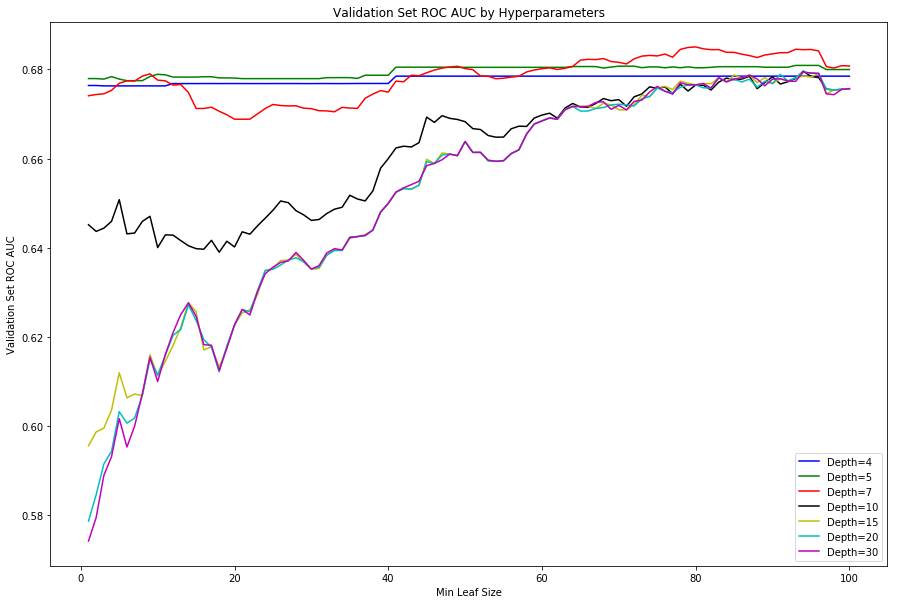

In [78]:
# Identify an optimal set of hyperparameters using ROC AUC and validation data
depths = [4, 5, 7, 10, 15, 20, 30]
leaves = np.arange(1, 101)

#Run all of the options
run=1
if (run == 1):
    #Initialize dictionary of results
    res = dict()
    for d in depths:
        res[d] = list()

    #Now train and get results for each option
    for d in depths:
        for l in leaves:
            clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = l, max_depth = d)
            clf = clf.fit(train_downsampled.drop('target', axis=1), train_downsampled.target)
            auc = roc_auc_score(valid.target, clf.predict_proba(valid.drop('target', axis=1))[:,1])
            res[d].append(auc)


#Now plot            
fig = plt.figure(figsize=(15, 10))
ax=fig.add_subplot(111)
plt.plot(leaves,res[depths[0]], 'b-', label = 'Depth={}'.format(depths[0]))
plt.plot(leaves,res[depths[1]], 'g-', label = 'Depth={}'.format(depths[1]))
plt.plot(leaves,res[depths[2]], 'r-', label = 'Depth={}'.format(depths[2]))
plt.plot(leaves,res[depths[3]], 'k-', label = 'Depth={}'.format(depths[3]))

plt.plot(leaves,res[depths[4]], 'y-', label = 'Depth={}'.format(depths[4]))
plt.plot(leaves,res[depths[5]], 'c-', label = 'Depth={}'.format(depths[5]))
plt.plot(leaves,res[depths[6]], 'm-', label = 'Depth={}'.format(depths[6]))


plt.legend(loc = 4)
ax.set_xlabel('Min Leaf Size')
ax.set_ylabel('Validation Set ROC AUC')
plt.title('Validation Set ROC AUC by Hyperparameters')

Trees with depth=7 seem to be performing better judging by their higher ROC AUCs. Below I look up the optimal min_samples_leaf for depth=7.

In [117]:
# Look up which depth gives the highest ROC AUC (depth=7)
for d in depths:
    print(d, '----', format(max(res[d]), '.3f'))
print()
print()

    
# Look up which min_samples_leaf gives the highest ROC AUC    
for l in leaves:
    if res[7][l-1] == max(res[7]):
        print(l, '----', format(res[7][l-1], '.3f' ))    

4 ---- 0.678
5 ---- 0.681
7 ---- 0.685
10 ---- 0.680
15 ---- 0.679
20 ---- 0.679
30 ---- 0.679


80 ---- 0.685


In [80]:
# Next, fit a regularized decision tree classifier on the DOWNSAMPLED training set 
clf_dwn_reg = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 80, max_depth = 7)
clf_dwn_reg = clf_dwn_reg.fit(train_downsampled.drop(['target'], axis=1),train_downsampled['target'])


Feature Importance for Regularized DT trained on downsampled training data


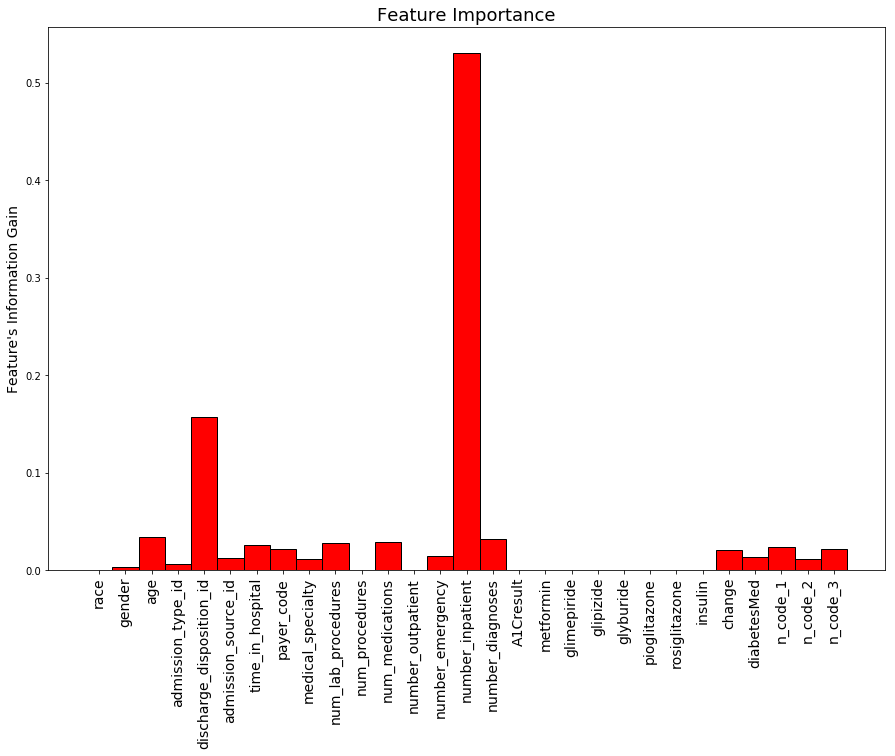

Features by Importance (Information gain or decrease in entropy)


[('number_inpatient', '0.531'),
 ('discharge_disposition_id', '0.158'),
 ('age', '0.034'),
 ('number_diagnoses', '0.032'),
 ('num_medications', '0.029'),
 ('num_lab_procedures', '0.029'),
 ('time_in_hospital', '0.026'),
 ('n_code_1', '0.024'),
 ('payer_code', '0.022'),
 ('n_code_3', '0.022'),
 ('change', '0.021'),
 ('diabetesMed', '0.014'),
 ('number_emergency', '0.014'),
 ('admission_source_id', '0.013'),
 ('medical_specialty', '0.012'),
 ('n_code_2', '0.011'),
 ('admission_type_id', '0.006'),
 ('gender', '0.003'),
 ('pioglitazone', '0.000'),
 ('num_procedures', '0.000'),
 ('glimepiride', '0.000'),
 ('metformin', '0.000'),
 ('insulin', '0.000'),
 ('race', '0.000'),
 ('glipizide', '0.000'),
 ('A1Cresult', '0.000'),
 ('number_outpatient', '0.000'),
 ('glyburide', '0.000'),
 ('rosiglitazone', '0.000')]

In [82]:
print("Feature Importance for Regularized DT trained on downsampled training data")
feature_importance(clf_dwn_reg, train_downsampled)

Observations:
- The regularized decision tree trained on downsampled training data suggests a somewhat different set of important predictors of readmissions: Number of impatient visits in the year preceeding the encounter, discharge disposition, patient's age, number of diagnoses, but still includes the number of medications and lab tests administered during the current encounter. 

In [83]:
# Next print model evaluation metrics and compare them to the previous set of results
print("Model evaluation metrics for REGULARIZED DT trained on DOWNSAMPLED TRAIN DATA (depth=7 & min_samples_leaf = 80): ")
print()
metrics(train_downsampled, valid, clf_dwn_reg)

Model evaluation metrics for REGULARIZED DT trained on DOWNSAMPLED TRAIN DATA (depth=7 & min_samples_leaf = 80): 

Accuracy in training data: 0.662
Accuracy in validation data: 0.678

METRICS BELOW ARE PRODUCED USING VALIDATION DATA:

Number of true positives:  982
Number of false negatives:  728

Number of true negatives:  8508
Number of false positives:  3780

True positive rate = Sensitivity = Recall:  0.574
False negative rate:  0.426

True negative rate = Specificity:  0.692
False positive rate:  0.308

Precision:  0.206

F1 score:  0.303

ROC AUC:  0.685

Average precision-recall score:  0.242


In [118]:
print("Performance metrics using DOWNSAMPLED TRAIN DATA and an unregularized tree:")
print()
metrics(train_downsampled, valid, clf_dwn_unr)

Performance metrics using DOWNSAMPLED TRAIN DATA and an unregularized tree:

Accuracy in training data: 1.000
Accuracy in validation data: 0.563

METRICS BELOW ARE PRODUCED USING VALIDATION DATA:

Number of true positives:  1004
Number of false negatives:  706

Number of true negatives:  6876
Number of false positives:  5412

True positive rate = Sensitivity = Recall:  0.587
False negative rate:  0.413

True negative rate = Specificity:  0.560
False positive rate:  0.440

Precision:  0.156

F1 score:  0.247

ROC AUC:  0.573

Average precision-recall score:  0.142


Observations:
- Sensitivity declined slightly from 0.587 to 0.574
- Precision improved from 0.156 to 0.206
- FPR rate declined from 0.440 to 0.308 and specificity increased
- ROC AUC and the average precision-recall score both increased


Next, I repeat the regularization exercise by using an alternative metric, the average precision score that captures the tradeoff between false positives and false negatives and is recommended when the target variabe is unbalanced (as precision and recall do not rely on the (typically large) number of true negatives). ROC is about the tradeoff between true positives and false positives. "The value is between 0 and 1 and higher is better." 

References:

http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics

http://www.chioka.in/differences-between-roc-auc-and-pr-auc/

Text(0.5,1,'Validation Set Precision-Recall Average Precision Score by Hyperparameters')

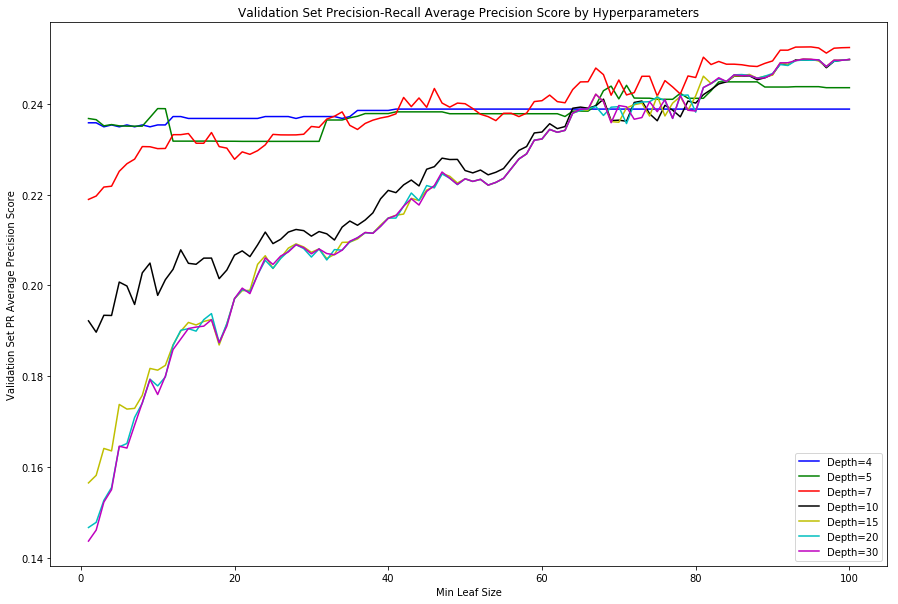

In [85]:
# Identify an optimal set of hyperparameters using the average precision score and validation data
depths = [4, 5, 7, 10, 15, 20, 30]
leaves = np.arange(1, 101)

#Run all of the options
run=1
if (run == 1):
    #Initialize dictionary of results
    res1 = dict()
    for d in depths:
        res1[d] = list()

    #Now train and get results for each option
    for d in depths:
        for l in leaves:
            clf_a = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = l, max_depth = d)
            clf_a = clf_a.fit(train_downsampled.drop('target', axis=1), train_downsampled.target)
            y_score = clf_a.predict_proba(valid.drop('target', axis=1))[:,1]
            average_precision = average_precision_score(valid.target, y_score)
            res1[d].append(average_precision)

#Now plot            
fig = plt.figure(figsize=(15, 10))
ax=fig.add_subplot(111)
plt.plot(leaves,res1[depths[0]], 'b-', label = 'Depth={}'.format(depths[0]))
plt.plot(leaves,res1[depths[1]], 'g-', label = 'Depth={}'.format(depths[1]))
plt.plot(leaves,res1[depths[2]], 'r-', label = 'Depth={}'.format(depths[2]))
plt.plot(leaves,res1[depths[3]], 'k-', label = 'Depth={}'.format(depths[3]))

plt.plot(leaves,res1[depths[4]], 'y-', label = 'Depth={}'.format(depths[4]))
plt.plot(leaves,res1[depths[5]], 'c-', label = 'Depth={}'.format(depths[5]))
plt.plot(leaves,res1[depths[6]], 'm-', label = 'Depth={}'.format(depths[6]))


plt.legend(loc = 4)
ax.set_xlabel('Min Leaf Size')
ax.set_ylabel('Validation Set PR Average Precision Score')
plt.title('Validation Set Precision-Recall Average Precision Score by Hyperparameters')

Again, trees with depth=7 seem to be performing better judging by their higher average precision scores. Below I look up the optimal min_samples_leaf for depth=7.


In [87]:
# Look up which depth gives the highest average precision score (depth=7)
for d in depths:
    print(d, '----', format(max(res1[d]), '.3f'))
print()
print()
    
# Look up which min_samples_leaf gives the highest average precision score
for l in leaves:
    if res1[7][l-1] == max(res1[7]):
        print(l, '----', format(res1[7][l-1], '.3f' ))
    

4 ---- 0.239
5 ---- 0.245
7 ---- 0.252
10 ---- 0.250
15 ---- 0.250
20 ---- 0.250
30 ---- 0.250


95 ---- 0.252


In [89]:
# Fit a regularized decision tree classifier on the DOWNSAMPLED train set using the new min_samples_leaf=95 and same depth=7
clf_dwn_reg_pr = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 95, max_depth = 7)
clf_dwn_reg_pr = clf_dwn_reg_pr.fit(train_downsampled.drop(['target'], axis=1),train_downsampled['target'])


In [90]:
# Next print model evaluation metrics and compare them to the previous set of results
print("Model evaluation metrics for REGULARIZED DT trained on DOWNSAMPLED TRAIN DATA (depth=7 & min_samples_leaf = 95): ")
print()
metrics(train_downsampled, valid, clf_dwn_reg_pr)

Model evaluation metrics for REGULARIZED DT trained on DOWNSAMPLED TRAIN DATA (depth=7 & min_samples_leaf = 95): 

Accuracy in training data: 0.660
Accuracy in validation data: 0.682

METRICS BELOW ARE PRODUCED USING VALIDATION DATA:

Number of true positives:  985
Number of false negatives:  725

Number of true negatives:  8556
Number of false positives:  3732

True positive rate = Sensitivity = Recall:  0.576
False negative rate:  0.424

True negative rate = Specificity:  0.696
False positive rate:  0.304

Precision:  0.209

F1 score:  0.307

ROC AUC:  0.684

Average precision-recall score:  0.252


Observations:

The differences in results of the current and previous models are marginal. 

The next thing I want to try is to use an upsampled dataset. In previous steps, I downsampled the majority (negative) class and lost a lot of potentially valuable information. Now, I will upsample the minority (positive) class so that the number of observations with target=1 matches the number of observations with target = 0 in the original training dataset. 

# Upsampling the minority (positive) class

In [92]:
 # Upsample the minority class (target=1)
train_1_upsampled = resample(train_1, replace=True, n_samples=len(train_0), random_state=350) 
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_0, train_1_upsampled])
 
# Display new class counts
train_upsampled.target.value_counts()

# (adapted from https://elitedatascience.com/imbalanced-classes)    

1    36648
0    36648
Name: target, dtype: int64

Next, I find the optimal set of regularization parameters using models trained on the upsampled training data and evaluated on validation data. I use the average precision score criterion.

Text(0.5,1,'Validation Set Precision-Recall Average Precision by Hyperparameters. Upsampled training data.')

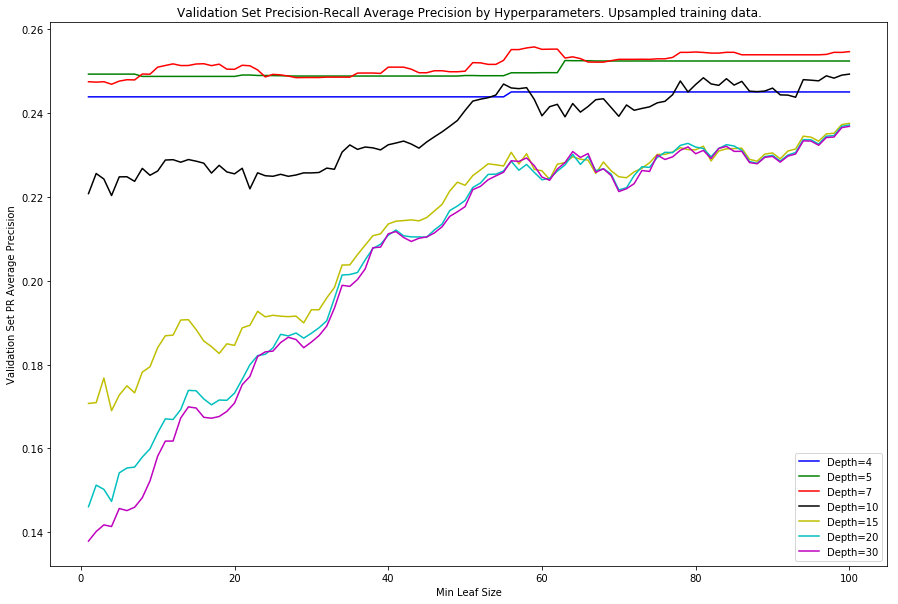

In [93]:
# Identify an optimal set of hyperparameters using the average precision score and validation data
depths = [4, 5, 7, 10, 15, 20, 30]
leaves = np.arange(1, 101)

#Run all of the options
run=1
if (run == 1):
    #Initialize dictionary of results
    res2 = dict()
    for d in depths:
        res2[d] = list()

    #Now train and get results for each option
    for d in depths:
        for l in leaves:
            clf_1 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = l, max_depth = d)
            clf_1 = clf_1.fit(train_upsampled.drop('target', axis=1), train_upsampled.target)
            y_score = clf_1.predict_proba(valid.drop('target', axis=1))[:,1]
            average_precision = average_precision_score(valid.target, y_score)
            res2[d].append(average_precision)

#Now plot            
fig = plt.figure(figsize=(15, 10))
ax=fig.add_subplot(111)
plt.plot(leaves,res2[depths[0]], 'b-', label = 'Depth={}'.format(depths[0]))
plt.plot(leaves,res2[depths[1]], 'g-', label = 'Depth={}'.format(depths[1]))
plt.plot(leaves,res2[depths[2]], 'r-', label = 'Depth={}'.format(depths[2]))
plt.plot(leaves,res2[depths[3]], 'k-', label = 'Depth={}'.format(depths[3]))

plt.plot(leaves,res2[depths[4]], 'y-', label = 'Depth={}'.format(depths[4]))
plt.plot(leaves,res2[depths[5]], 'c-', label = 'Depth={}'.format(depths[5]))
plt.plot(leaves,res2[depths[6]], 'm-', label = 'Depth={}'.format(depths[6]))


plt.legend(loc = 4)
ax.set_xlabel('Min Leaf Size')
ax.set_ylabel('Validation Set PR Average Precision')
plt.title('Validation Set Precision-Recall Average Precision by Hyperparameters. Upsampled training data.')

In [94]:
# Look up which depth gives the highest average precision score (depth=7)
for d in depths:
    print(d, '----', format(max(res2[d]), '.3f'))
print()
print()
    
# Look up which min_samples_leaf gives the highest average precision score
for l in leaves:
    if res2[7][l-1] == max(res2[7]):
        print(l, '----', format(res2[7][l-1], '.3f' ))
    

4 ---- 0.245
5 ---- 0.253
7 ---- 0.256
10 ---- 0.249
15 ---- 0.238
20 ---- 0.237
30 ---- 0.237


59 ---- 0.256


The best pair of hyperparameters appears to be depth=7 and min_samples_leaf=59. Proceed to estimate a new regularized decision tree on the upsampled training data using the average precision score criterion.

In [119]:
# Fit a regularized decision tree classifier on the UPSAMPLED train set 
clf_up_reg_pr = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 59, max_depth = 7)
clf_up_reg_pr= clf_up_reg_pr.fit(train_upsampled.drop(['target'], axis=1),train_upsampled['target'])


Feature Importance for Regularized DT trained on upsampled training data


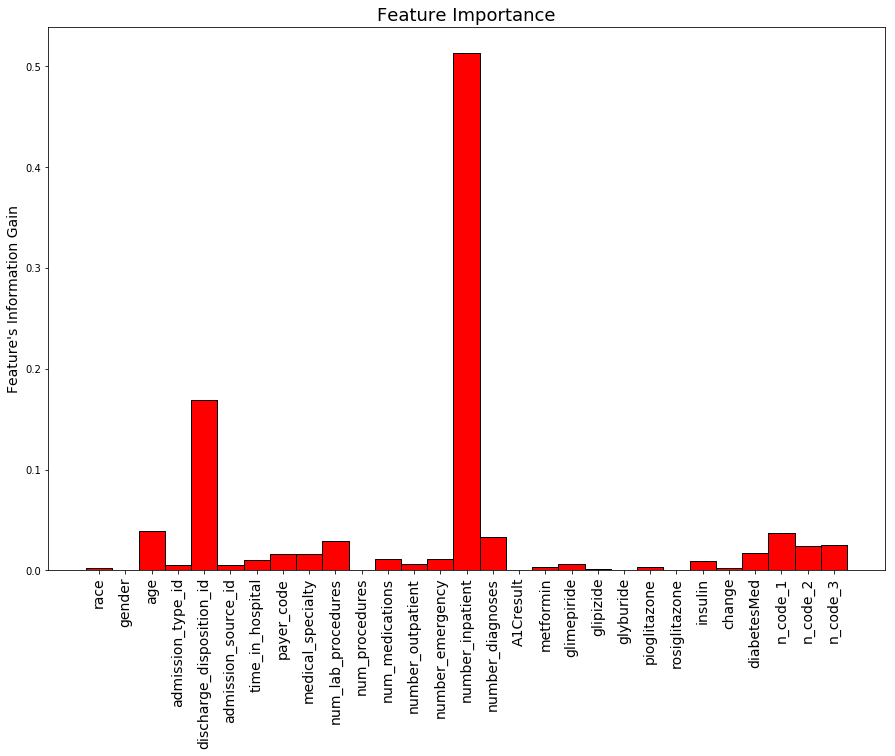

Features by Importance (Information gain or decrease in entropy)


[('number_inpatient', '0.514'),
 ('discharge_disposition_id', '0.169'),
 ('age', '0.039'),
 ('n_code_1', '0.037'),
 ('number_diagnoses', '0.033'),
 ('num_lab_procedures', '0.029'),
 ('n_code_3', '0.025'),
 ('n_code_2', '0.024'),
 ('payer_code', '0.017'),
 ('diabetesMed', '0.017'),
 ('medical_specialty', '0.016'),
 ('num_medications', '0.012'),
 ('time_in_hospital', '0.011'),
 ('number_emergency', '0.011'),
 ('insulin', '0.009'),
 ('glimepiride', '0.006'),
 ('number_outpatient', '0.006'),
 ('admission_type_id', '0.005'),
 ('admission_source_id', '0.005'),
 ('pioglitazone', '0.003'),
 ('metformin', '0.003'),
 ('race', '0.003'),
 ('glipizide', '0.002'),
 ('change', '0.002'),
 ('num_procedures', '0.000'),
 ('gender', '0.000'),
 ('A1Cresult', '0.000'),
 ('glyburide', '0.000'),
 ('rosiglitazone', '0.000')]

In [120]:
print("Feature Importance for Regularized DT trained on upsampled training data")
feature_importance(clf_up_reg_pr, train_upsampled)


In [121]:
# Next print model evaluation metrics and compare them to the previous set of results
print("Model evaluation metrics for REGULARIZED DT trained on UPSAMPLED TRAIN DATA (depth=7 & min_samples_leaf = 59): ")
print()
metrics(train_upsampled, valid, clf_up_reg_pr)

Model evaluation metrics for REGULARIZED DT trained on UPSAMPLED TRAIN DATA (depth=7 & min_samples_leaf = 59): 

Accuracy in training data: 0.659
Accuracy in validation data: 0.662

METRICS BELOW ARE PRODUCED USING VALIDATION DATA:

Number of true positives:  1043
Number of false negatives:  667

Number of true negatives:  8221
Number of false positives:  4067

True positive rate = Sensitivity = Recall:  0.610
False negative rate:  0.390

True negative rate = Specificity:  0.669
False positive rate:  0.331

Precision:  0.204

F1 score:  0.306

ROC AUC:  0.677

Average precision-recall score:  0.256


In [99]:
print("Validation set metrics using DOWNSAMPLED TRAIN DATA & REGULARIZED TREE (depth=7 & min_samples_leaf = 95): ")
print()
metrics(train_downsampled, valid, clf_dwn_reg_pr)

Validation set metrics using DOWNSAMPLED TRAIN DATA & REGULARIZED TREE (depth=7 & min_samples_leaf = 95): 

Accuracy in training data: 0.660
Accuracy in validation data: 0.682

METRICS BELOW ARE PRODUCED USING VALIDATION DATA:

Number of true positives:  985
Number of false negatives:  725

Number of true negatives:  8556
Number of false positives:  3732

True positive rate = Sensitivity = Recall:  0.576
False negative rate:  0.424

True negative rate = Specificity:  0.696
False positive rate:  0.304

Precision:  0.209

F1 score:  0.307

ROC AUC:  0.684

Average precision-recall score:  0.252


# Final set of observations

Observations:

- Important features seem to be the very similar to what we got with downsampled training data    


- Sensitivity or TPR goes up to 0.610 (the highest that we've seen so far)


- Specificity (TNR), precision, ROC AUC and F1 score decline very slightly compared to the previous model (regularized DT on downsampled data) (remember that hyperparameters were chosen using the average precision score, not ROC AUC)


- Average precision score increases very slightly 


Overall, the model performance has improved: the declines that we observe are very marginal, but the improvement in sensitivity is quite noticeable and gives us the lowest false negative rate so far.

# Suggested next steps

- Spend some time understanding where your last model makes mistakes. Study (eye-ball) the relationship between main predictors and the target variable. 


- Depth of 7 seems to give the highest ROC AUC and average precision scores. Investiage other depths around 7 (i.e., depth=6,8, and 9).


- One of the limitations of Decision Trees is that if some data patterns were not present in the training dataset but show up in the validation set, the DT won't "know" how to classify those types of observations. So, maybe the model could be improved further if one uses cross-validation where we use all slices of our data to train models.


- Consider implementing AdaBoost where models (DTs) would be trained in sequence to improve the performance of weak learners.


- Could try a random forest model though here we seem to have a bigger problem with improving predictions (random forests are great at dealing with overfitting and reducing variance).


- Consider keeping original categories for diagnosis and medication variables. This more granular information may reveal new valuable patterns. Note that when we reduced the cardinality of diag_1, diag_2, and diag_3, we introduced many missing values.


- Consider reestimating the model where the target is 1 if readmitted within 30 days and 0 if NOT readmitted (i.e., drop the readmitted after 30 days category).


- Try a different set of (still relatively simple) models like a logistic regression or SVM. For this, need to pre-process data: de-mean and normalize numeric variables and create dummy variables for categorical variables. 


- More involved: Go to the original data source and see if can obtain more information. For example, basic data on the date of the encounter, hospital, and patient's zip code (or even county) may give a significant boost to the model performance. Encounters in 1999 are likely markedly different from encounters in 2008, and currently we are not able to accout for these differences. Hospitals differ widely in their quality and performance, and this could also be an important predictor of readmissions. Finally, the patient's location may shed some more light on his/her socio-demographic characteristics, some of which could be important.



- More involved: It could be useful (but expensive) to have more details about exact procedures performed, more detailed provider characteristics, etc.







(To be continued...)